# Predicting Customer Turnover with Machine Learning Models

## Introduction

In this scenario we are working for Beta Bank. The bank has identified a problem: customers are leaving little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

Our task is to predict whether a customer will leave the bank soon. Using the data on clients’ past behavior and termination of contracts with the bank, we must build a model that will accurately predict if a client is going to leave.  Our model must obtain an F1 score of at least 0.59 to pass.  We'll also measure the AUC-ROC metric of the final model.

To complete this task, we'll first build and train a model without taking class balance into account.  Once our baseline is set, we'll attempt to fix the class imbalance and find a best model.  Finally, the model will be used on our test set.

We'll start by importing our necessary libraries and data:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.utils import shuffle

In [ ]:
df = pd.read_csv('Churn.csv')

## Data PreProcessing

### First Look

Now let's examine the data we have.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


We notice that only one of our columns has missing values: `Tenure`.  Let's take a closure look at the information our DataFrame contains so that we may determine the best way to prepare our data.

In [4]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


We have 14 columns in our data set.  The `Exited` column is our target - the value we are trying to predict.   Our other columns contain a mix of identifying information and financial information about a customer.  Some of these columns may have an impact on whether a client leaves the bank, while others likely have no effect.  In order to produce the best model, we should remove the columns from our dataset that likely have no impact on the target.  The `RowNumber`, `CustomerId`, and `Surname` will all likely have no effect and will be excluded from our model.

We're left with the following features that will be used to predict our target:
- `CreditScore`
- `Geography` — country of residence
- `Gender`
- `Age`
- `Tenure` — period of maturation for a customer’s fixed deposit (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — customer has a credit card
- `IsActiveMember` — customer’s activeness
- `EstimatedSalary` — estimated salary

While most of these columns are numerical, there are two columns with strings that we'll need to address: `Geography` and `Gender`.  

### Data Cleaning

We'll quickly check for duplicated rows.

In [5]:
df.duplicated().sum()

0

In [6]:
df["CustomerId"].duplicated().sum()

0

Let's look at the missing values we have.

In [7]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [8]:
df.Tenure.value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

At even a quick glance, we can see that the values are quite evenly spread, with only values of 0 and 10 having significantly less instances than other values.  We'll fill our missing values with the median, so as not to reduce our already small dataset.

In [9]:
df["Tenure"] = df["Tenure"].fillna(df["Tenure"].median())

In [10]:
df.Tenure.value_counts(dropna=False)

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: Tenure, dtype: int64

Next we'll reduce our dataset by dropping the columns of `RowNumber`, `CustomerId`, and `Surname`, as we won't need these for our model.

In [11]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [12]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

Next let's address our columns of strings by using One-Hot Encoding.

In [13]:
obj_columns = list(df.select_dtypes(include=['object']).columns)

In [14]:
obj_columns

['Geography', 'Gender']

Before we proceed with OHE, we'll first check how many values each column has.  If a column has many unique values, it may be better to use label encoding.

In [15]:
display(df.Geography.nunique())
df.Gender.nunique()

3

2

Our columns of type `object` have only a small number of unique values, and our data is nominal (not ordinal), so OHE will suffice.

In [16]:
df = pd.get_dummies(df, drop_first=True)

Let's examine our final DataFrame that we'll use to train our models.

In [17]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


## Visualizing our Data

Before we make our first model, let's visualize a few of the columns in our dataset.  First is our Credit Score column.

### Credit Score

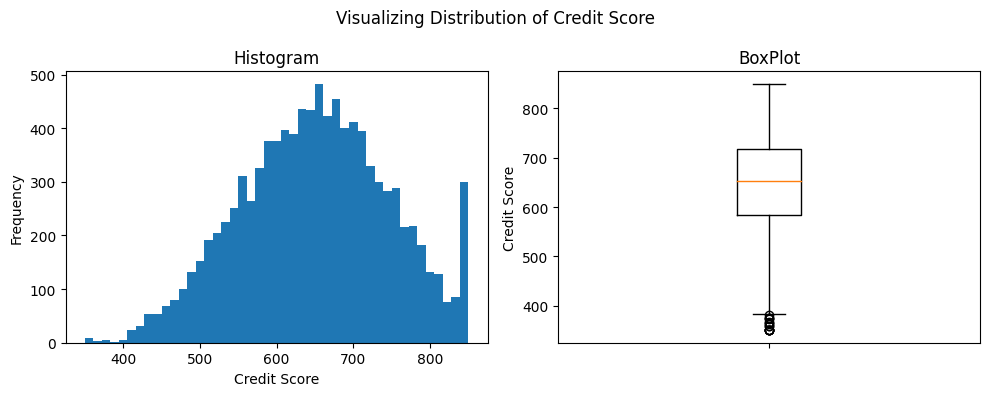

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

fig.suptitle("Visualizing Distribution of Credit Score")

axes[0].hist(df['CreditScore'], bins=45)
axes[0].set_title('Histogram')
axes[0].set_xlabel("Credit Score")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(df['CreditScore'])
axes[1].set_title('BoxPlot')
axes[1].set_ylabel("Credit Score")
axes[1].set_xticklabels("")


plt.tight_layout()
plt.show()

In [19]:
df.CreditScore.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [20]:
df.CreditScore.value_counts()[850]

233

Our Credit Score column appears to be roughly distributed normally, with some outliers at the lower end and an interesting case at the maximum end.  We notice that the top most bin has a large number of occurances.  233 of these occurances are from customers that have the maximum possible CreditScore of 850 (FICO).  The credit scores are approximately centered around 650, with both the mean and median being very close to this value.

### Age

We can use the same types of graphs to visualize our `Age` column.  Age has a lower number of discrete possiblities, so we can use a Histogram that has more bins than we might normally use to represent each possible value in our dataset.

In [21]:
df.Age.max() - df.Age.min()

74

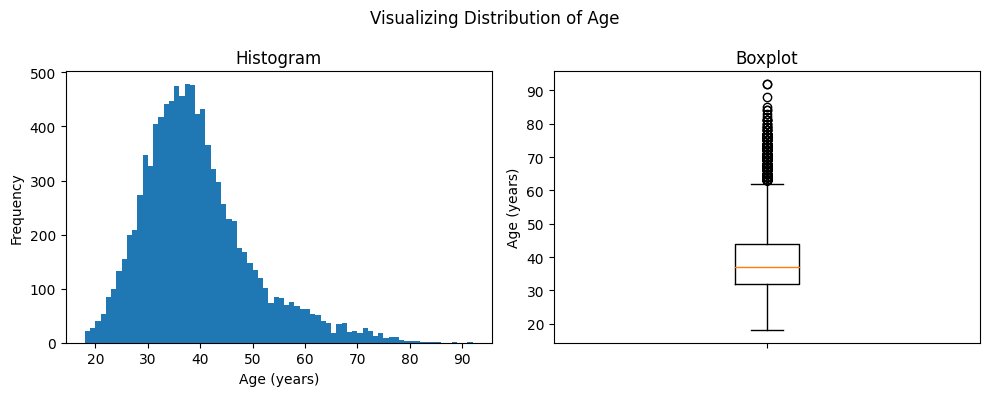

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

fig.suptitle("Visualizing Distribution of Age")

axes[0].hist(df.Age, bins=74)
axes[0].set_title('Histogram')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df.Age)
axes[1].set_title('Boxplot')
axes[1].set_xticklabels('')
axes[1].set_ylabel('Age (years)')


plt.tight_layout()
plt.show()

In [23]:
df.Age.describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

Our Age column is slightly skewed to the right, with a center just under 40 years of age. Half of the bank's customers in this dataset are between 32 and 44 years of age (our IQR). Our data contains outliers in the upper range.

### Salary

We'll examine our `EstimatedSalary` column the same way we examined our other two `Age` and `CreditScore` columns.

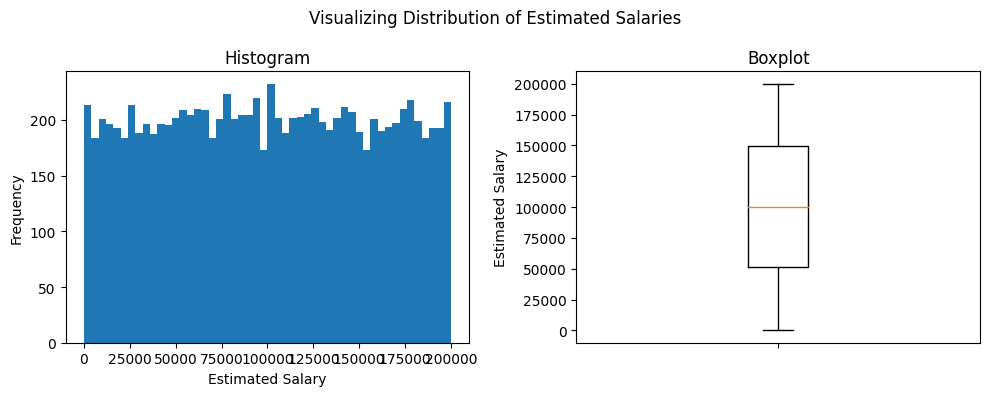

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

fig.suptitle("Visualizing Distribution of Estimated Salaries")

axes[0].hist(df.EstimatedSalary, bins=50)
axes[0].set_title('Histogram')
axes[0].set_xlabel('Estimated Salary')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df.EstimatedSalary)
axes[1].set_title('Boxplot')
axes[1].set_xticklabels('')
axes[1].set_ylabel('Estimated Salary')


plt.tight_layout()
plt.show()

In [25]:
df.EstimatedSalary.describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

The `EstimatedSalary` column is more unique than the previous two columns we examined.  The values in this column are distribued almost uniformly.   This column is centered near 100,000.  These values seem a bit strange, as it is unlikely that anyone is making a salary of 11.58.  It's possible that the EstimatedSalary column may be a column we wish to ignore in a test case when creating models. 

## Class Balance 

Let's examine our class balance for the target.

In [26]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

We'll save our ratio for later, as we'll need it for resampling.

In [27]:
ratio = 7237/1854

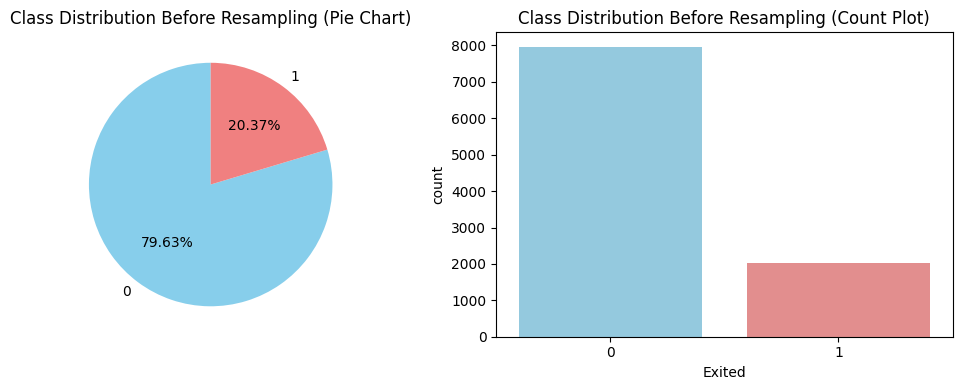

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

pie_colors = ['skyblue', 'lightcoral']
axes[0].pie(df['Exited'].value_counts(), labels = df['Exited'].value_counts().index, autopct='%1.2f%%', startangle=90, colors=pie_colors)
axes[0].set_title('Class Distribution Before Resampling (Pie Chart)')

countplot_colors = sns.color_palette(pie_colors)
sns.countplot(x='Exited', data=df, palette=countplot_colors, ax=axes[1])
axes[1].set_title('Class Distribution Before Resampling (Count Plot)')


plt.tight_layout()
plt.show()


We can see that our classes are not balanced.  In other words,  roughly 20% of our clients exited, while 80% remained.  Ideally, this spread would be closer to 50/50 to train our model.

Let's define a function that we can use to plot our piechart after resampling later.

In [29]:
def plot_resample_results(y_resampled, title):
    plt.figure(figsize=(4, 4))
    pd.Series(y_resampled).value_counts().plot.pie(autopct='%2.2f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    plt.title(title)
    plt.show

We'll first train our model without accounting for this imbalance.

## First Models

### Data Preperation

We start by identifying our target and features.

In [30]:
target = df['Exited']
features = df.drop('Exited', axis=1)

Next we split our data into training (60%), validation(20%), and test sets(20%).

In [31]:
features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, random_state=12345)

Finally, we scale our non-boolean columns.

In [32]:
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,0,1,1
3411,711,37,8.0,113899.92,1,0,0,80215.20,0,0,0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1,0,1
1247,512,24,6.0,0.00,2,1,0,37654.31,0,0,1
3716,665,27,2.0,147435.96,1,0,0,187508.06,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,549,31,4.0,0.00,2,0,1,25684.85,0,0,1
4094,513,29,10.0,0.00,2,0,1,25514.77,0,0,1
3492,655,45,5.0,57327.04,1,0,1,47349.00,0,0,0
2177,667,24,4.0,0.00,2,0,1,34335.55,0,0,0


In [33]:
#scale our numeric columns
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_100/2610552148.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_100/2610552148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Now that we have our data split and scaled appropriately, we can use our classification models.  For each type of model, we'll run a few variations to try and find the best hyperparameters to use.

### Decision Tree Models

In [34]:
best_tree_model = None
best_tree_score = 0
best_tree_depth = 0

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_tree_score:
        best_tree_model = model
        best_tree_score = score
        best_tree_depth = depth

print(f"F1 Score of the best model on the validation set (max_depth = {best_tree_depth}): {best_tree_score}")

F1 Score of the best model on the validation set (max_depth = 6): 0.5696969696969697


### Random Forest Models

In [35]:
best_forest_model = None
best_forest_score = 0
best_forest_est = 0
best_forest_depth = 0

for est in range(10, 51, 10):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_forest_score:
            best_forest_model = model
            best_forest_score = score
            best_forest_est = est
            best_forest_depth = depth
print(f"F1 Score of the best model on the validation set (n_estimators = {best_forest_est}, max_depth = {best_forest_depth}): {best_forest_score}")

F1 Score of the best model on the validation set (n_estimators = 10, max_depth = 10): 0.5891238670694864


### Regression Model

In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
regres_f1 = f1_score(target_valid, predicted_valid)
print(
    "F1 Score of the logistic regression model on the validation set:", regres_f1
)

F1 Score of the logistic regression model on the validation set: 0.33108108108108103


### Comparison

In [37]:
print(f"F1 Score of the best model: {best_tree_score:.5}")
print(f"F1 Score of the best model: {best_forest_score:.5}")
print(f"F1 Score of the logistic regression model: {regres_f1:.5}")

F1 Score of the best model: 0.5697
F1 Score of the best model: 0.58912
F1 Score of the logistic regression model: 0.33108


We can see that our DecisionTree and RandomForest models faired quite similarly, with the RandomForest coming out slightly on top.  Our RandomForestModel almost passes our F1 requirement of 0.59, but just misses the mark.  Our logistic regression model performed poorly in comparison.

## Impoving our Model

### Upsampling

One method we can to treat class imbalance it to use Upsampling, or Oversampling.  This strategy allows us to introduce more instances of the class that was underrepresented - in our case, a row where our target has a value of 1.  To do this we can define our own function.   

In [38]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

Now we upsample our data:

In [39]:
#ftu = features_trainingset_upsampled
ftu, ttu = upsample(features_train, target_train, int(ratio))

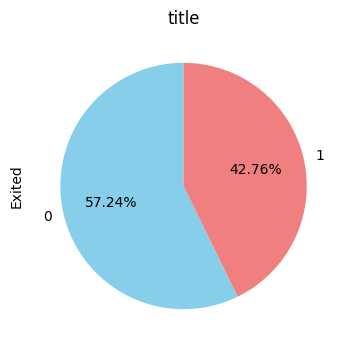

In [40]:
plot_resample_results(ttu, "title")

After Upsampling, we can see that our classes are more closely balanced.  However, a slight imbalance still exists.  Let's see how this impacts our models:

#### Decision Tree Models

In [41]:
best_uptree_model = None
best_uptree_score = 0
best_uptree_depth = 0

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(ftu, ttu)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_uptree_score:
        best_uptree_model = model
        best_uptree_score = score
        best_uptree_depth = depth

print(f"F1 Score of the best model on the validation set (max_depth = {best_uptree_depth}): {best_uptree_score}")

F1 Score of the best model on the validation set (max_depth = 5): 0.586374695863747


#### Random Forest Models

In [42]:
best_upforest_model = None
best_upforest_score = 0
best_upforest_est = 0
best_upforest_depth = 0

for est in range(10, 51, 10):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(ftu, ttu)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_upforest_score:
            best_upforest_model = model
            best_upforest_score = score
            best_upforest_est = est
            best_upforest_depth = depth
print(f"F1 Score of the best model on the validation set (n_estimators = {best_upforest_est}, max_depth = {best_upforest_depth}): {best_upforest_score}")

F1 Score of the best model on the validation set (n_estimators = 40, max_depth = 6): 0.6364692218350754


#### Regression Model

In [43]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(ftu, ttu)
predicted_valid = model.predict(features_valid)
upregres_f1 = f1_score(target_valid, predicted_valid)
print(
    "F1 Score of the logistic regression model on the validation set:", upregres_f1
)

F1 Score of the logistic regression model on the validation set: 0.5


#### Comparison

In [44]:
print(f"F1 Score of the best model: {best_uptree_score:.5}")
print(f"F1 Score of the best model: {best_upforest_score:.5}")
print(f"F1 Score of the logistic regression model: {upregres_f1:.5}")

F1 Score of the best model: 0.58637
F1 Score of the best model: 0.63647
F1 Score of the logistic regression model: 0.5


- From oversampling, our DecisionTreeClassifier has improved, but not quite enough to pass our target of 0.59.  While small, the improvement is noticeable.  
- Our RandomForestModel's F1 Score also increased significantly (about 0.05) and now passes our target of 0.59.  
- Our Regression Model saw the most improvement, jumping up by roughly 0.17.  However, the Regression Model's score still does not meet our target.
- Main takeaway: Our RandomForestModel is once again our best model, with an F1 score of roughly 0.636.

### Undersampling

Similar to our Up/Over Sampling method, we can do the opposite.  Rather than create more instances of the minority class (the underrepresented values), we can instead reduce instances of the majority class (the overrepresented values).  Let's quickly define a function to accomplish this:

In [45]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

Now we undersample our data: 

In [46]:
#ftd = features_trainingset_downsampled
ftd, ttd = downsample(features_train, target_train, 1/ratio)

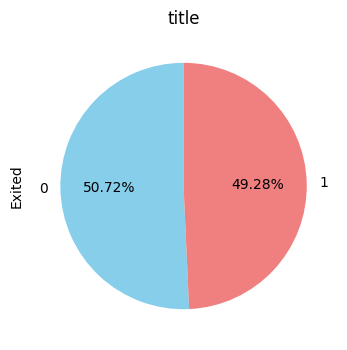

In [47]:
plot_resample_results(ttd, "title")

Our Undersampling method provided a more balanced result than our Oversampling function, as the function we created for downsampling is able to utilize a fraction instead of an integer.  Let's build our models. 

#### Decision Tree Models

In [48]:
best_downtree_model = None
best_downtree_depth = 0
best_downtree_score = 0

for depth in range (1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(ftd, ttd)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_downtree_score:
        best_downtree_model = model
        best_downtree_depth = depth
        best_downtree_score = score
        
print(f"F1 Score of the best model on the validation set (max_depth = {best_downtree_depth}): {best_downtree_score}")

F1 Score of the best model on the validation set (max_depth = 6): 0.5754141238012206


#### Random Forest Models

In [49]:
best_downforest_model=None
best_downforest_est=0
best_downforest_depth=0
best_downforest_score=0

for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(ftd, ttd)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_downforest_score:
            best_downforest_model = model
            best_downforest_est = est
            best_downforest_depth = depth
            best_downforest_score = score

print(f"F1 Score of the best model on the validation set (n_estimators = {best_downforest_est}, max_depth = {best_downforest_depth}): {best_downforest_score}")

F1 Score of the best model on the validation set (n_estimators = 50, max_depth = 7): 0.6088631984585742


#### Regression Model

In [50]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(ftd, ttd)
predicted_valid = model.predict(features_valid)
downregres_f1 = f1_score(target_valid, predicted_valid)
print(
    "F1 Score of the logistic regression model on the validation set:", downregres_f1
)

F1 Score of the logistic regression model on the validation set: 0.4837861524978088


#### Comparison

In [51]:
print(f"F1 Score of the best model: {best_downtree_score:.5}")
print(f"F1 Score of the best model: {best_downforest_score:.5}")
print(f"F1 Score of the logistic regression model: {downregres_f1:.5}")

F1 Score of the best model: 0.57541
F1 Score of the best model: 0.60886
F1 Score of the logistic regression model: 0.48379


Our 

Our downsampling method, while better than our baseline, underperforms in comparison to our Upsampling

- From undersampling, our DecisionTreeClassifier performs similarly to our baseline model; the F1 score only slightly improves.  
- Our RandomForestModel's F1 Score increased slightly and passes our target of 0.59.  
- Our Regression Model saw the most improvement with undersampling, jumping up by 0.2.  However, the Regression Model's score still does not meet our target.

- Main takeaway: Our RandomForestModel is once again our best model, with an F1 score of roughly 0.608.

From testing different models we have one Key Point to mention.  Out of all models, our Upsampling method yielded the best results for all models.  The overall best model was our Upsampled RandomForestModel.

## Final Model

In [52]:
print(f"Our overall best model was our Upsampled RandomForest Model with the following parameters: \n n_estimators: {best_upforest_est} \n max_depth: {best_upforest_depth}")
print(f"Our model obtained an F1 Score of {best_upforest_score:.5f} on the validation set.")

Our overall best model was our Upsampled RandomForest Model with the following parameters: 
 n_estimators: 40 
 max_depth: 6
Our model obtained an F1 Score of 0.63647 on the validation set.


Now lets use our model on our final test set and see the values we obtain:

In [53]:
model = best_upforest_model
model.fit(ftu, ttu)
predicted_test = model.predict(features_test)
final_score = f1_score(target_test, predicted_test)
print(final_score)

0.5909617612977984


Our final model has an F1 Score of 0.59 on the test set.  We've just cleared our target!  Let's examine our AUC-ROC score as well.

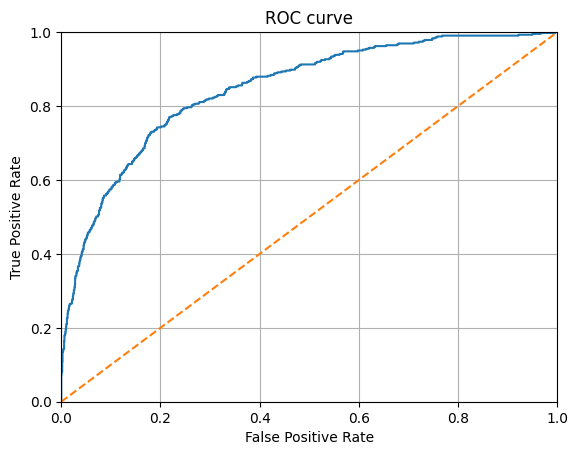

In [54]:
#plotting our curve
probs_test = model.predict_proba(features_test)
probs_one_valid = probs_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probs_one_valid)
plt.figure()
plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title("ROC curve")
plt.show()

In [55]:
print(f" ROC AUC of our final model on the test set: {roc_auc_score(target_test, predicted_test):.5f}")

 ROC AUC of our final model on the test set: 0.74276


## Conclusions

Through testing multiple models, we were able to produce a final model that passes our F1 Score requirement of 0.59.  

We tested three different kinds of models:
- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression

In all of our tests, the RandomForestClassifier produced the best model.  When working to improve our baseline models, Upsampling created the greatest improvement.  We selected a RandomForestClassifier model that uses Upsampling for our final model. 

Our final model had an F1 score of 0.5909 on the testing set.  While there is certainly room for improvement towards perfect precision and recall, our score is acceptable for this task.  We've also obtained an AUC score of 0.74276.  We'd say this score is moderately accurate.  Again, while there is room for improvement, our model shows that is has at least some ability to predict correctly.